## Meta data

### Simple empty maze

In [ ]:
import numpy as np

x = np.array([[1, 1, 1, 1, 1, 1], 
              [1, 0, 0, 0, 0, 1], 
              [1, 0, 0, 0, 0, 1], 
              [1, 0, 0, 0, 0, 1], 
              [1, 0, 0, 0, 0, 1], 
              [1, 1, 1, 1, 1, 1]])
start_idx = [[1, 1]]
goal_idx = [[4, 4]]
env_id = 'SimpleEmptyMaze-v0'

### Tilt Maze 1

In [1]:
import numpy as np

x = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
              [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
              [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
              [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
              [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
              [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
start_idx = [[1, 1]]
goal_idx = [[9, 8]]
env_id = 'TiltMaze-v0'

### Double T-maze

In [ ]:
from mazelab.generators import double_t_maze

x = double_t_maze()
print(x)

start_idx = [[8, 6]]
goal_idx = [[1, 1]]
env_id = 'DoubleTMaze-v0'

### U-maze

In [ ]:
from mazelab.generators import u_maze

x = u_maze(width=10, height=9, obstacle_width=6, obstacle_height=3)
print(x)

start_idx = [[8, 1]]
goal_idx = [[1, 1]]
env_id = 'UMaze-v0'

### Random shapes maze

In [ ]:
from mazelab.generators import random_shape_maze

x = random_shape_maze(width=50, height=50, max_shapes=50, max_size=8, allow_overlap=False, shape=None)
print(x)

start_idx = [[1, 1]]
goal_idx = [[48, 48]]
env_id = 'RandomShapeMaze-v0'

### Random maze

In [ ]:
from mazelab.generators import random_maze

x = random_maze(width=81, height=51, complexity=.75, density=.75)
print(x)

start_idx = [[1, 1]]
goal_idx = [[49, 79]]
env_id = 'RandomMaze-v0'

### Morris water maze

In [ ]:
from mazelab.generators import morris_water_maze

x = morris_water_maze(radius=20, platform_center=[15, 30], platform_radius=4)
print(x)

start_idx = [[3, 15]]
goal_idx = np.stack(np.where(x == 3), axis=1)
env_id = 'MorrisWaterMaze-v0'

## Make Environment

In [2]:
import numpy as np
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color


class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal
        

In [3]:
from mazelab import BaseEnv
from mazelab import VonNeumannMotion

import gym
from gym.spaces import Box
from gym.spaces import Discrete


class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()
        

In [4]:
gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=200)

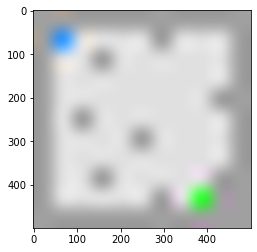

In [5]:
import matplotlib.pyplot as plt

env = gym.make(env_id)
env.reset()
img = env.render('rgb_array')
plt.imshow(img)

In [6]:
from mazelab.solvers import dijkstra_solver

impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)
env = gym.wrappers.Monitor(env, './', force=True)
rewards = 0.0
env.reset()
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
env.close()
print(rewards)

[1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3]
0.86


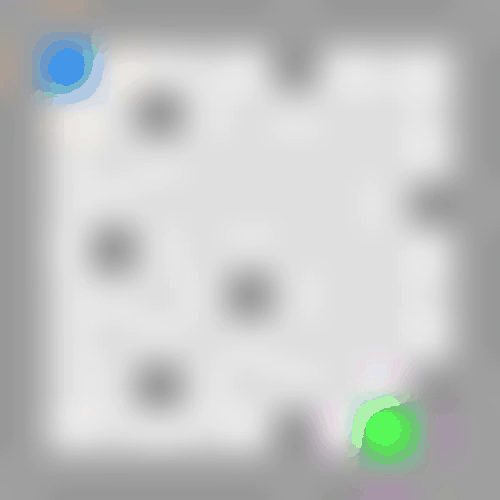

In [7]:
import imageio
from IPython.display import Image
from pathlib import Path
f = list(Path('./').glob('*.mp4'))[0]
reader = imageio.get_reader(f)
f = f'./{env_id}.gif'
with imageio.get_writer(f, fps=3) as writer:
    [writer.append_data(img) for img in reader]
Image(f)